# 1. OPTIMIZING MODEL PARAMETERS

Now that we have a model and data it’s time to train, validate and test our model by optimizing its parameters on our data. Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates the error in its guess (loss), collects the derivatives of the error with respect to its parameters, and **optimizes** these parameters using gradient descent. For a more detailed walkthrough of this process, check out this video on [backpropagation from 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

## a. Prerequisite Code

We load the code from the previous sections.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor


# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    ])

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform_train
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform_test
)

for dset in [training_data, test_data]:
    idx = (dset.targets==0) | (dset.targets==1)
    dset.targets = dset.targets[idx]
    dset.data = dset.data[idx]

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=28*28):
        super().__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.classifier(x)
        return x


model = NeuralNetwork().to(device)
print(model)

Using mps device


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=2, bias=True)
    (1): Sigmoid()
  )
)


## b. Hyperparameters

Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates.

We define the following hyperparameters for training:
- **Number of Epochs** - the number times to iterate over the dataset

- **Batch Size** - the number of data samples propagated through the network before the parameters are updated

- **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [2]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

## c. Optimization Loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an **epoch**.

Each epoch consists of two main parts:
- **The Train Loop** - iterate over the training dataset and try to converge to optimal parameters.

- **The Validation/Test Loop** - iterate over the test dataset to check if model performance is improving.

### I. Loss Function

When presented with some training data, our untrained network is likely not to give the correct answer. **Loss function** measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include `nn.MSELoss` (Mean Square Error) for regression tasks, and `nn.NLLLoss` (Negative Log Likelihood) for classification. `nn.CrossEntropyLoss` combines `nn.LogSoftmax` and `nn.NLLLoss`.

We pass our model’s output logits to `nn.CrossEntropyLoss`, which will normalize the logits and compute the prediction error.

In [3]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### II. Optimizer

We need to improve the model's performance by minimizing a 'loss function'. This process of adjusting the model's 'parameters' is what we call 'optimization'.

However, the challenge is that the more complex the model becomes, the more difficult it is to find the optimal parameters using calculus alone.

This is where 'Gradient Descent' comes into play. The principle behind Gradient Descent is to change the parameters little by little in the direction that lowers the current loss value.

In fact, the concept of Gradient Descent is at the heart of what we call 'Optimization Algorithms'. These algorithms are designed to efficiently find the optimal parameters, even in complex models.


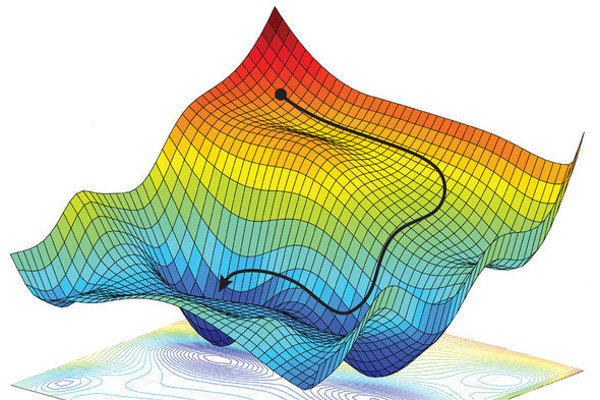

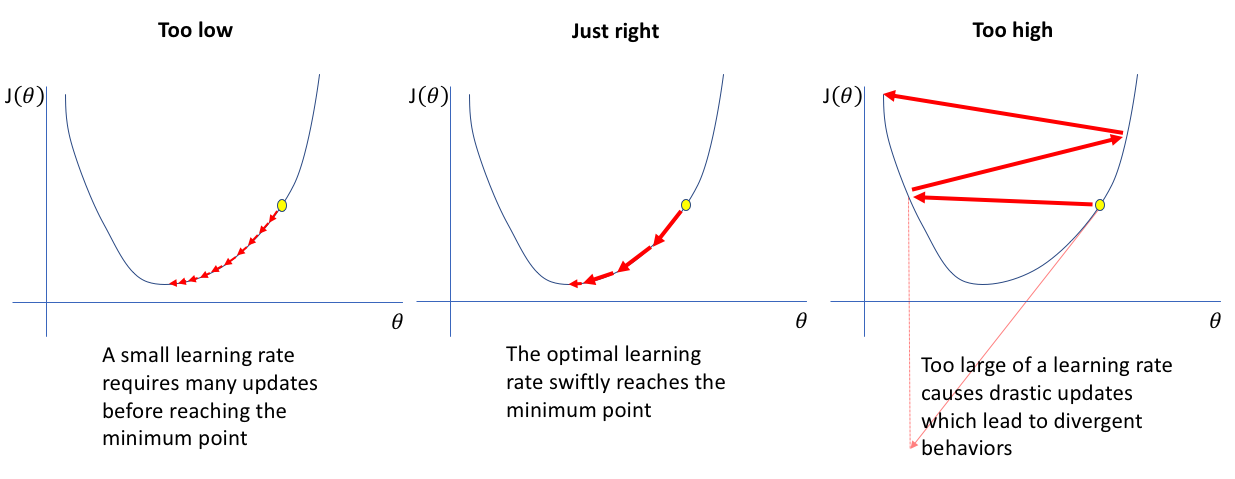

In an Optimizer, there is an important hyperparameter called the learning rate, which determines the size of the adjustments made to the parameters. If it's too small, it takes a long time to converge; if it's too large, it may not converge at all. Therefore, it's crucial to fine-tune the learning rate appropriately.

Optimization is the process of adjusting model parameters to reduce model error in each training step. **Optimization algorithms** define how this process is performed (in this example we use Stochastic Gradient Descent). All optimization logic is encapsulated in the `optimizer` object. Here, we use the SGD optimizer; additionally, there are many [different optimizers](https://pytorch.org/docs/stable/optim.html) available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.



We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter.

In [4]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:
- Call `optimizer.zero_grad()` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.

- Backpropagate the prediction loss with a call to `loss.backward()`. PyTorch deposits the gradients of the loss w.r.t. each parameter.

- Once we have our gradients, we call `optimizer.step()` to adjust the parameters by the gradients collected in the backward pass.

### III. Full Implementation

We define `train_loop` that loops over our optimization code, and `test_loop` that evaluates the model’s performance against our test data.

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to `train_loop` and `test_loop`. Feel free to increase the number of epochs to track the model’s improving performance.

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(10):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.678987  [   64/12000]
loss: 0.671556  [ 3264/12000]
loss: 0.659775  [ 6464/12000]
loss: 0.645989  [ 9664/12000]
Test Error: 
 Accuracy: 93.3%, Avg loss: 0.635366 

Epoch 2
-------------------------------
loss: 0.649687  [   64/12000]
loss: 0.620766  [ 3264/12000]
loss: 0.608211  [ 6464/12000]
loss: 0.606583  [ 9664/12000]
Test Error: 
 Accuracy: 94.2%, Avg loss: 0.595889 

Epoch 3
-------------------------------
loss: 0.596369  [   64/12000]
loss: 0.590700  [ 3264/12000]
loss: 0.589636  [ 6464/12000]
loss: 0.573102  [ 9664/12000]
Test Error: 
 Accuracy: 94.5%, Avg loss: 0.565642 

Epoch 4
-------------------------------
loss: 0.557031  [   64/12000]
loss: 0.546664  [ 3264/12000]
loss: 0.548702  [ 6464/12000]
loss: 0.558704  [ 9664/12000]
Test Error: 
 Accuracy: 94.6%, Avg loss: 0.541166 

Epoch 5
-------------------------------
loss: 0.536748  [   64/12000]
loss: 0.563405  [ 3264/12000]
loss: 0.550920  [ 6464/12000]
loss: 0.526501  [ 9664

## d. Saving and Loading Model Weights

PyTorch models store the learned parameters in an internal state dictionary, called `state_dict`. These can be persisted via the `torch.save` method:

In [7]:
torch.save(model.state_dict(), './model_weights.pth')

To load model weights, you need to create an instance of the same model first, and then load the parameters using `load_state_dict()` method.

In [8]:
model = NeuralNetwork()
model.load_state_dict(torch.load('./model_weights.pth'))
model.to(device)
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=2, bias=True)
    (1): Sigmoid()
  )
)

be sure to call `model.eval()` method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.

When loading model weights, we needed to instantiate the model class first, because the class defines the structure of a network. We might want to save the structure of this class together with the model, in which case we can pass `model` (and not `model.state_dict()`) to the saving function:

In [9]:
torch.save(model, './model.pth')

We can then load the model like this:

In [10]:
model = torch.load('./model.pth').to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=2, bias=True)
    (1): Sigmoid()
  )
)


# Exercise

- Fill in the blanks(`pass`, `None`) in the following code to make a working linear regression model.
- Try to minimize the testset loss by changing the activation function, hyperparameters, etc.

In [43]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [44]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'mps' if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [45]:
# Create dataset
X, y = datasets.make_regression(
      n_samples=1000, n_features=10, noise=5, random_state=4)
y = y.reshape(-1, 1)

In [46]:
# Normalize the data
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

In [47]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
      X_scaled, y_scaled, test_size=0.33, random_state=42)

In [48]:
class CustomDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray) -> None:
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))

    def __getitem__(self, index: int) -> tuple:
        x = torch.FloatTensor(self.X[index])
        y = torch.FloatTensor(self.y[index])
        return (x, y)
        pass

    def __len__(self) -> int:
        return len(self.X)
        pass

In [49]:
# Generate the training dataset
traindata = CustomDataset(X_train, y_train)
testdata = CustomDataset(X_test, y_test)

In [50]:
batch_size = 64
num_workers = 0

# Load the training data into data loader with the
# respective batch_size and num_workers
trainloader = DataLoader(traindata,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=num_workers)
testloader = DataLoader(testdata, 
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers)

In [51]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim: int,
                  hidden_dim: int, output_dim: int) -> None:
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)

In [52]:
# number of features (len of X cols)
input_dim = X_train.shape[1]

# number of hidden layers
hidden_layers = 50

# output dimension is 1 because of linear regression
output_dim = 1

# initialize the model
model = LinearRegression(input_dim, hidden_layers, output_dim).to(device)
print(model)

LinearRegression(
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


In [53]:
# criterion to computes the loss between input and target
criterion = nn.CrossEntropyLoss()

# optimizer that will be used to update weights and biases
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [56]:
epochs = 1000
for epoch in range(epochs):
    print(f"Epoch {epoch}/{epochs}")

    for i, (inputs, labels) in enumerate(trainloader):
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn)

Epoch    0/1000 Batch 1/11 Cost : 0.104096
Epoch    0/1000 Batch 2/11 Cost : 0.109651
Epoch    0/1000 Batch 3/11 Cost : 0.088544
Epoch    0/1000 Batch 4/11 Cost : 0.102451
Epoch    0/1000 Batch 5/11 Cost : 0.118650
Epoch    0/1000 Batch 6/11 Cost : 0.094341
Epoch    0/1000 Batch 7/11 Cost : 0.082851
Epoch    0/1000 Batch 8/11 Cost : 0.114327
Epoch    0/1000 Batch 9/11 Cost : 0.091515
Epoch    0/1000 Batch 10/11 Cost : 0.088769
Epoch    0/1000 Batch 11/11 Cost : 0.076778
Epoch    1/1000 Batch 1/11 Cost : 0.085856
Epoch    1/1000 Batch 2/11 Cost : 0.107381
Epoch    1/1000 Batch 3/11 Cost : 0.091327
Epoch    1/1000 Batch 4/11 Cost : 0.094594
Epoch    1/1000 Batch 5/11 Cost : 0.080791
Epoch    1/1000 Batch 6/11 Cost : 0.105040
Epoch    1/1000 Batch 7/11 Cost : 0.072848
Epoch    1/1000 Batch 8/11 Cost : 0.079888
Epoch    1/1000 Batch 9/11 Cost : 0.082970
Epoch    1/1000 Batch 10/11 Cost : 0.096231
Epoch    1/1000 Batch 11/11 Cost : 0.086803
Epoch    2/1000 Batch 1/11 Cost : 0.100054
Epoch  

In [ ]:
# save the trained model
PATH = './mymodel.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
model = LinearRegression(input_dim, hidden_layers, output_dim)
model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()

In [ ]:
with torch.no_grad():
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(testloader):
        pass